In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

## for diverging colormaps with black in the middle
import cmasher as cmr
import logging

log = logging.getLogger(__name__)
# logging.basicConfig(level=logging.WARNING)

## Data 
Each file in the `yearly_grads` folder is a npz-file containing the following info:
- `outputs`: The model output for the given input data for 50 different dropout iterations for 12 months (1 year). 
Shape: (12, 432, 432, 3, 6), 12 months, 432x432 grid, 3 channels ($SIC < 15\%$, $15\% < SIC <80 \%$ and $80\% < SIC$) and 6 lead times.
- `grads`: The mean gradient of the loss with respect to the input data for 50 input channels using 25 dropout iterations (for the mean, that is). 
- `grads_std`: The standard deviation of the gradient values for all 50 input channels using 25 dropout iterations.
Shape: (12, 432, 432, 50), 12 months, 432x432 grid and 50 input variables.
- `TIME_STAMP`: The time stamp of the data used for the prediction.


In [2]:
DATA_PATH = "/Users/hjo109/Library/CloudStorage/OneDrive-UiTOffice365/need_to_clean/Documents/GitHub/icenet-paper/data/ordered_obs_npz/yearly_grads"

## Note! Weird lags
Data coming out of the loader is lagged by one year wrt. the time on the label. I cannon understand why, but this is the case for every year except for the first one. The first year (1980) is correct (i.e. the data in the file grads_1980_leadtime_0 is equal to that in file grads_1981_leadtime_0). The file for every year starts at March 1. and ends at February 28. 

In [3]:
## showing that the timestamps are the same (this is true for all leadtimes)
leadtime = 0

data_labelled_1980 = np.load(
    os.path.join(DATA_PATH, f"grads_1980_leadtime_{leadtime}.npz")
)
data_labelled_1981 = np.load(
    os.path.join(DATA_PATH, f"grads_1981_leadtime_{leadtime}.npz")
)

true_time_stamp_labelled_1980 = datetime.datetime.fromisoformat(
    str(data_labelled_1980["TIME_STAMP"])
)
true_time_stamp_labelled_1981 = datetime.datetime.fromisoformat(
    str(data_labelled_1981["TIME_STAMP"])
)

if true_time_stamp_labelled_1980 == true_time_stamp_labelled_1981:
    print("The timestamps are the same: ", true_time_stamp_labelled_1980)

The timestamps are the same:  1980-02-01 00:00:00


In [10]:
def get_data_from_year(year, leadtime):
    ## first get the data from the first month of the year (january) from the current year
    ## then get the rest from the next year (since weird time lag in the data)
    out_data = dict(
        TIME_STAMP=[None, None],
        grads=np.empty((12, 432, 432, 50)),
        grads_std=np.empty((12, 432, 432, 50)),
        outputs=np.empty((12, 432, 432, 3, 6)),
    )

    ## Get data for january and february
    filename = f"grads_{year}_leadtime_{leadtime}.npz"
    filepath = os.path.join(DATA_PATH, filename)
    data_jan = np.load(filepath)

    if year == 1980:
        log.info("actual time stamp for start" + str(data_jan["TIME_STAMP"]) + "+2")
    else:
        log.info("actual time stamp for start" + str(data_jan["TIME_STAMP"]) + "+11")

    ## Fill in the data
    out_data["TIME_STAMP"] = [
        datetime.datetime(year, 1, 1),
        datetime.datetime(year, 12, 31),
    ]
    if (
        year == 1980
    ):  ## special case for 1980 since we do not have data from before 1980-02-01
        out_data["grads"][0, ...] = np.nan
        out_data["grads_std"][0, ...] = np.nan
        out_data["outputs"][0, ...] = np.nan
        out_data["TIME_STAMP"][0] = datetime.datetime(year, 2, 1)
    else:
        out_data["grads"][0, ...] = data_jan["grads"][11:, ...]
        out_data["grads_std"][0, ...] = data_jan["grads_std"][11:, ...]
        out_data["outputs"][0, ...] = data_jan["outputs"][11:, ...]

    ## Get data for the rest of the year
    filename = f"grads_{year+1}_leadtime_{leadtime}.npz"
    filepath = os.path.join(DATA_PATH, filename)
    data_rest = np.load(filepath)

    log.info("actual time stamp for end" + str(data_rest["TIME_STAMP"]) + "+10")

    ## Fill in the data
    out_data["grads"][1:, ...] = data_rest["grads"][:11, ...]
    out_data["grads_std"][1:, ...] = data_rest["grads_std"][:11, ...]
    out_data["outputs"][1:, ...] = data_rest["outputs"][:11, ...]
    return out_data

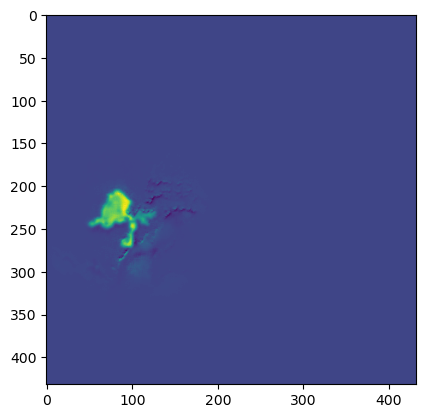

In [26]:
out = get_data_from_year(1980, 1)
grads = out["grads"]
plt.imshow(np.nanmean(grads, axis=(0, 3)))

## Diverging colors on colorbar centered at 0

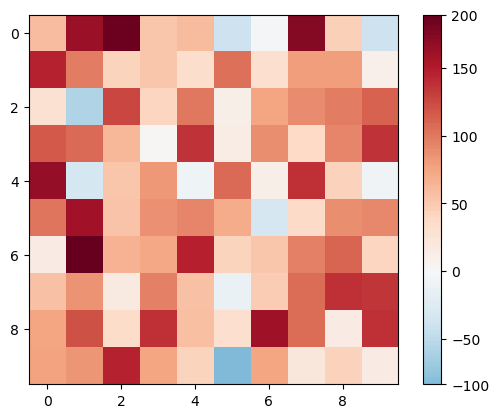

In [29]:
# Modified from source: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


class MidpointNormalize(mpl.colors.Normalize):
    """
    Make colorbar where the midpoint is at a specified value. Use example:
    ```{python}
        img = np.random.randn(10, 10) * 50 + 60
        ## either
        norm = MidpointNormalize(midpoint=0, vmin=-100, vmax=100)
        ## or
        norm = MidpointNormalize.from_img(img)
        plt.imshow(img, norm=norm)
        plt.colorbar()
        plt.show()
    ```
    """

    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(
            0,
            1
            / 2
            * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))),
        )
        normalized_max = min(
            1,
            1
            / 2
            * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))),
        )
        normalized_mid = 0.5
        x = [self.vmin, self.midpoint, self.vmax]
        y = [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

    @staticmethod
    def from_img(img):
        vmin = np.min(img)
        vmax = np.max(img)
        midpoint = 0
        return MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)


def mpn(img):
    """Quick notation for midpoint normalize."""
    return MidpointNormalize.from_img(img)


## Example
img = np.random.randn(10, 10) * 50 + 60
cmap = "RdBu_r"

plt.imshow(img, norm=mpn(img), cmap=cmap)
plt.colorbar()

## Example mean gradients for a given year, month and leadtime

In [34]:
## Example
year = 2000
leadtime = 5
month = 7
relevant_area = (slice(160, 310), slice(20, 190))

# fig, ax = plt.subplots(1, 1990-1981, figsize=(10, 50))
to_cat = []

for leadtime in range(6):
    to_cat_leadtime = []
    for i, year in enumerate([1982]):
        data = get_data_from_year(year, leadtime)
        grads = data["grads"]

        img = grads[month, :, :, 5][relevant_area]
        to_cat_leadtime.append(img)
    to_cat.append(np.concatenate(to_cat_leadtime, axis=1))

    # img = np.apply_over_axes(lambda x, axes: np.max(np.abs(x), axes), grads[:, :, :, :], axes=2)[relevant_area]

img = np.concatenate(to_cat, axis=0)
norm = MidpointNormalize.from_img(img)
plt.imshow(img, norm=norm, cmap=cmr.iceburn)
time_stamp = data["TIME_STAMP"]
# plt.set_title(year)
plt.axis("off")
plt.xlabel("Year")
plt.ylabel("Leadtime")
# plt.title(time_stamp)
plt.savefig(f"test.pdf", dpi=3000, bbox_inches="tight", pad_inches=0)

ValueError: Cannot load file containing pickled data when allow_pickle=False

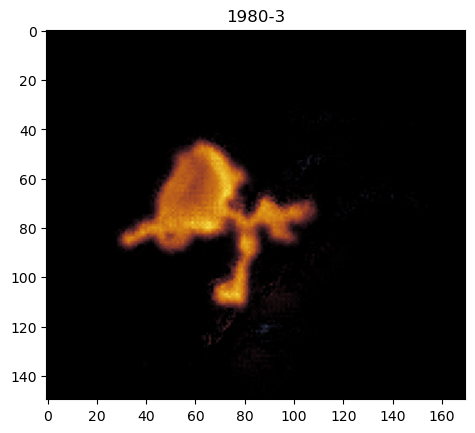

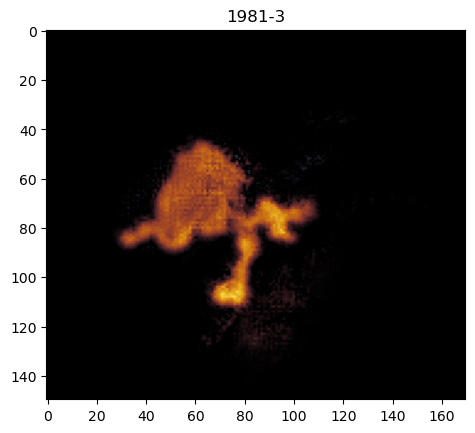

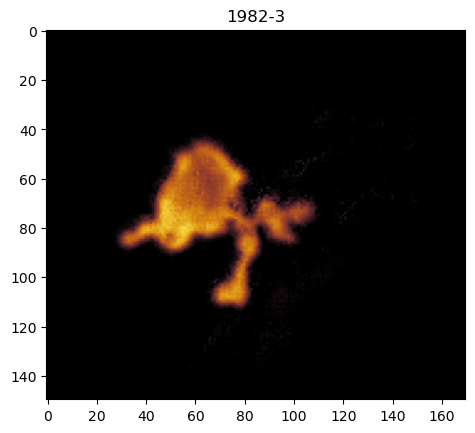

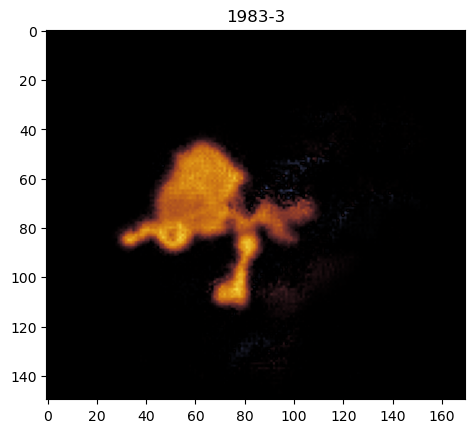

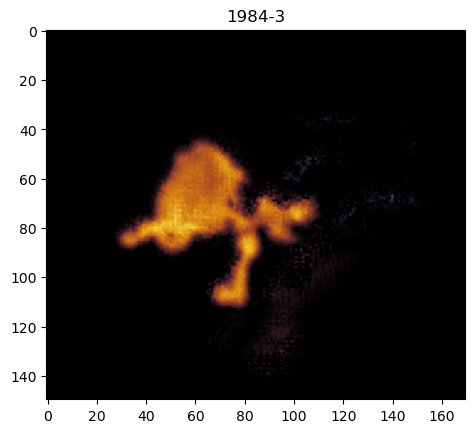

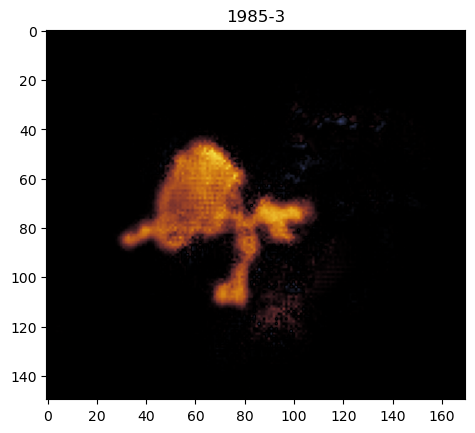

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [35]:
## Example over years but for the same month
month = 3  ## March
leadtime = 5  ## predicting 6 months ahead, i.e. september
years = np.arange(1980, 1997)
relevant_area = (slice(160, 310), slice(20, 190))
img = np.zeros((150, 170, 1))

for year in years:
    data_y = get_data_from_year(year, leadtime)
    grads_y = data_y["grads"]

    img_y = np.apply_over_axes(np.mean, grads_y[month, :, :, 5:6], axes=2)[
        relevant_area
    ]
    img = img_y
    # img += img_y

    ## taking mean rather than sum
    # img /= len(years)
    plt.imshow(img, norm=MidpointNormalize.from_img(img), cmap=cmr.iceburn)
    plt.title(f"{year}-{month}")
    plt.show()
    ## sleep to see the images

## Feature importance over time

### Feature importance for January 1. in the years 1980, 1985, 1990, 1995 and 2000, 2005 shown side by side as images (similar to the ones in the paper).

#### Expermient: 
Divide by the sum of the absolute values of the columns. Each column represents the importance of all the inputs for the prediction of The Hudson Bay System a leadtime. Dividing by the sum of absolute values makes the combined importance score of all the inputs equal to 1 making the influences comparable. (Is this really the case? An input typical values provides less total information than an input with a lot of extreme values so the total influence might not be 1.)

Anyway, here it is:


ValueError: Cannot load file containing pickled data when allow_pickle=False

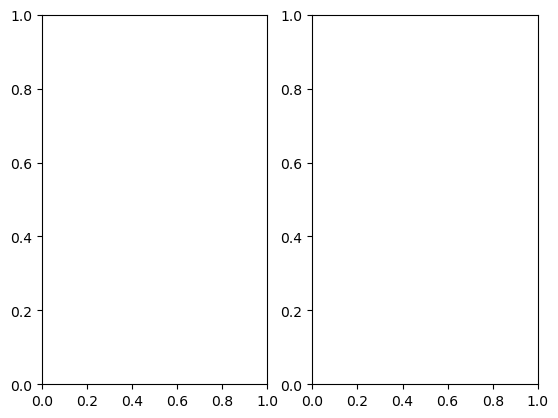

In [39]:
normalize_by_column = False
month = 1  ## Looking at january
years = [1982, 1984]  # , 1990, 1995, 2000, 2005]
# relevant_area = [slice(160, 310), slice(20, 190)]

fig, ax = plt.subplots(1, len(years))
relevance_map = np.zeros((50, 6))

# relevance_over_time = np.zeros((*relevance_map, len(years)))

for i, year in enumerate(years):
    for leadtime in range(6):
        data = get_data_from_year(year, leadtime=leadtime)
        ## Find the most relevant pixel for each location for each input variable
        relevance = np.max(np.abs(data["grads"]), axis=(1, 2))[month : month + 1, ...]
        if normalize_by_column:
            relevance = relevance / np.sum(np.abs(relevance), axis=0)

        relevance_map[:, leadtime] = relevance

    # max_idx0 = np.argrank(relevance_map, axis=0)
    # max_idx1 = np.argrank(relevance_map, axis=1)

    ax[i].imshow(
        np.abs(relevance_map),
        cmap=cmr.iceburn,
        # norm=MidpointNormalize.from_img(relevance_map)
    )
    ax[i].axis("off")
    ax[i].set_title(f"{year}-{month}")
# plt.savefig("figures/feature_importance/feature_importance_over_time_imgs.pdf", dpi=3000, bbox_inches="tight", pad_inches=0)

In [ ]:
max_idx0

### Do the same standardization of color as they did
clip_values = (0, 0.5)

## Feature importance maps over time 

In [89]:
month = 1  ## January
years = np.arange(1981, 2000)
# relevant_area = [slice(160, 310), slice(20, 190)]

# fig, ax = plt.subplots(1, 5)
# relevance_map = np.zeros((50, 6))

relevance_over_time = np.zeros((50, 6, len(years)))

for i, year in enumerate(years):
    for leadtime in range(6):
        data = get_data_from_year(year, leadtime=leadtime)
        ## Find the most relevant pixel for each location for each input variable
        relevance = np.max(np.abs(data["grads"]), axis=(1, 2))[month : month + 1, ...]
        # relevance_map[:, leadtime] = relevance

        relevance_over_time[:, leadtime, i] = relevance

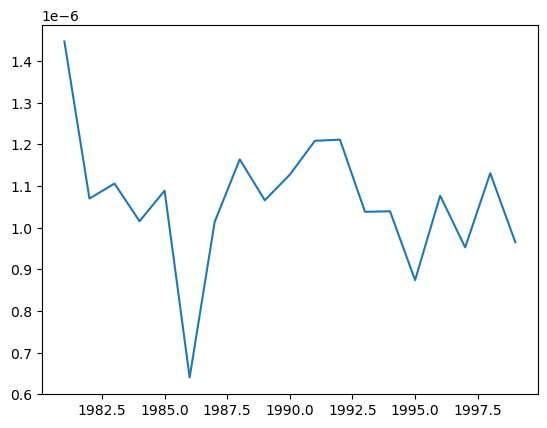

In [91]:
plt.plot(years, relevance_over_time[0, 0, :])

In [83]:
from scipy.stats import pearsonr


p_values = np.zeros((50, 6))
for i in range(50):
    for j in range(6):
        p_values[i, j] = pearsonr(years, relevance_over_time[i, j, :])[1]

### P-values for the correlation between the feature importance and the year
I.e. If there are significant changes in the feature importance over time, there should be a disproportional amount of significant p-values.

(array([27., 18., 22., 22., 19., 27., 20., 16., 27., 16., 19., 20., 17.,
        10., 20.]),
 array([0.00159835, 0.06803105, 0.13446374, 0.20089644, 0.26732913,
        0.33376183, 0.40019452, 0.46662721, 0.53305991, 0.5994926 ,
        0.6659253 , 0.73235799, 0.79879069, 0.86522338, 0.93165607,
        0.99808877]),
 <BarContainer object of 15 artists>)

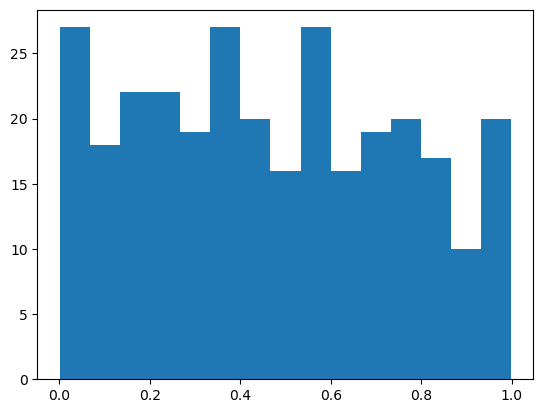

In [88]:
plt.hist(p_values.flatten(), bins=15)

# plt.imshow(signif_mask, cmap=cmr.iceburn)

# plt.plot(years, relevance_over_time)
# idx[0, :].shape